<a href="https://colab.research.google.com/github/rrfsantos/Segmentacao-de-Clientes-e-Predicao-de-Campanha-de-Marketing/blob/main/Clusteriza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!python -m pip install -U matplotlib
#!python -m pip install -U pandas

In [2]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import re
import time
import datetime as dt
import itertools
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime

%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/iFood/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Pré processamento do Dataset para entrada nos modelos de Machine Learning

In [4]:
# Carregando dataset
data = pd.read_csv('ml_project1_data.csv', engine='python')

In [5]:
# Substituindo valores nulos na coluna 'Income' pela mediana - A base é muito pequena, melhor não deletar linhas
df = data.copy()
median_value = df.Income.median()
df.Income.fillna(value = median_value, inplace=True)

In [6]:
# Removendo as colunas Z_CostContact e Z_Revenue
df.drop(columns=['ID', 'Z_CostContact',	'Z_Revenue'], inplace=True)

In [7]:
#for col in ['AcceptedCmp3',	'AcceptedCmp4',	'AcceptedCmp5',	'AcceptedCmp1',	'AcceptedCmp2',	'Complain',	'Response', 'Kidhome', 'Teenhome']:
   # df[col] = df[col].astype('object')

In [8]:
# Tranformando a coluna Dt_Customer em número de dias (data fim 2015-01-01)
end_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y.%m.%d')

days = lambda x: int((end_date - x).days)
df.Dt_Customer = df.Dt_Customer.apply(days)

In [9]:
# Substituindo ano menor que 1920 na coluna 'Year_Birth' pela mediana
median_value = df.Year_Birth.median()
mask = df.Year_Birth < 1920
column_name = 'Year_Birth'
df.loc[mask, column_name] = median_value

In [10]:
# Substituindo 'Alone', 'Absurd' e 'YOLO' por 'Single'
single = lambda x: re.sub(r'Alone|Absurd|YOLO', 'Single', x)
df.Marital_Status = df.Marital_Status.apply(single)

In [11]:
# Removendo renda maior que 100k - Estava interferindo na construção dos clusters
df.drop(df[df.Income > 100000].index, inplace=True)

In [12]:
# Transformando variáveis não numéricas em numéricas
le_e = LabelEncoder()
df['Education'] = le_e.fit_transform(df['Education'])

le_m = LabelEncoder()
df['Marital_Status']  = le_m.fit_transform(df['Marital_Status'])

In [13]:
# Substituindo features correlacionadas por sua média
column = df.loc[: , 'MntWines':'MntGoldProds']
df['MntProducts'] = column.mean(axis=1)
df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds'], inplace=True)

In [14]:
# Substituindo features correlacionadas por sua média
column = df.loc[: , 'AcceptedCmp3':'AcceptedCmp2']
df['AcceptedCmp'] = column.mean(axis=1)
df.drop(columns=['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1', 'AcceptedCmp2'], inplace=True)

## Segmentação dos entrevistados

In [15]:
X = df.loc[:, df.columns != 'Response']
y = df.Response

### Clusterização utilizando K-means

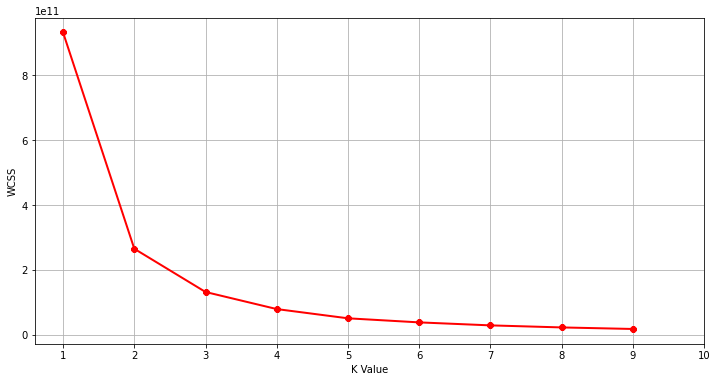

In [16]:
# Identificando o número ótimo de clusters
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,10),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [17]:
# K-means
n_clusters = 3

def doKmeans(data, nclust):
    kmeans = KMeans(nclust)
    kmeans.fit(data)
    clust_labels = kmeans.predict(data)
    cent = kmeans.cluster_centers_
    return (clust_labels, cent)
    
cluster_labels, cent = doKmeans(X, n_clusters)
cluster_num = pd.DataFrame(cluster_labels)
df.insert((df.shape[1]),'cluster_num', cluster_num)

silhouette_avg = silhouette_score(X, cluster_labels)
print( "For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.5541396600433508


In [18]:
# Revertendo o label encoder
df['Education'] = le_e.inverse_transform(df['Education'])
df['Marital_Status']  = le_m.inverse_transform(df['Marital_Status'])

### Analisando os Clusters

* Cluster 0: Satisfeitos com a loja

Grupo com maior proporção de entrevistados com gradução, um pouco mais velhos e com menor número de filhos em casa, têm a maior remuneração (75k), consequentemente, apresentam o maior montante em compras. Número baixo de reclamções comparado com o seu volume de compra. Compra menos produtos em oferta e apresenta a melhor aceitação para campanhas. Grupo que mais compra via Web, apesar de ser o que faz menos visitas ao site da loja.

* Cluster 1: Reclamam muito e compram pouco

Clientes mais jovens com filhos pequenos, têm a menor remuneração (30k), consequentemente, apresentam o menor montante em compras. Grupo que apresenta o maior número de reclamações, visitam a loja online com frequência, mas não efetivam compras. Apesar da melhor aceitação na última campanha, tem histórico de não adesão. Nesse grupo se concentram os entrevistados com ensino médio. Menor frequência de divorciados e viúvos e maior frequência de solteiros.

* Cluster 2: Procuram ofertas

Grupo com maior proporção de entrevistados com pós-gradução, tem mesma média de idade que o cluster 0, com filhos adolescentes e remuneração média (50k). Apresentam o maior volume de compras em ofertas e baixa adesão às campanhas.

(0.0, 400.0)

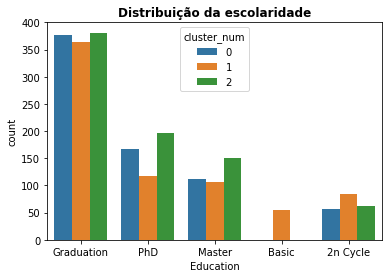

In [40]:
ax = sns.countplot(x="Education", hue="cluster_num", data=df)
ax.set_title('Distribuição da escolaridade', fontsize=12, fontweight='bold')
plt.ylim(0, 400)
plt.show()

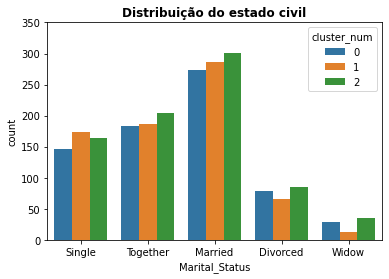

In [43]:
ax = sns.countplot(x="Marital_Status", hue="cluster_num", data=df)
ax.set_title('Distribuição do estado civil', fontsize=12, fontweight='bold')
plt.ylim(0, 350)
plt.show()

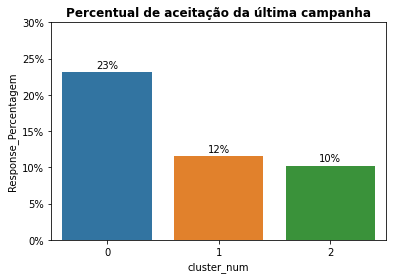

In [21]:
# Verificando o percentual de aceitação da última campanha
df_response_cluster = df.groupby('cluster_num')['Response'].value_counts(normalize=True).reset_index(name='Response_Percentagem')
df_response_cluster_1 = df_response_cluster.loc[df_response_cluster['Response'] == 1]

fig, ax = plt.subplots()
sns.barplot(x='cluster_num', y='Response_Percentagem', data=df_response_cluster_1, ax=ax)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_title('Percentual de aceitação da última campanha', fontsize=12, fontweight='bold')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 0.3)
plt.show();    

In [22]:
df_mean = df.groupby(['cluster_num']).mean().reset_index()

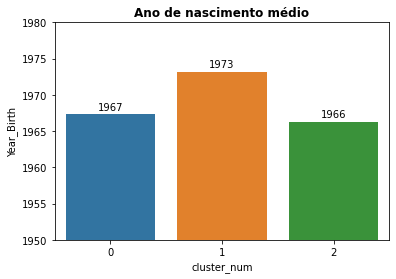

In [23]:
ax = sns.barplot(x='cluster_num', y='Year_Birth', data=df_mean)
ax.set_title('Ano de nascimento médio', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(1950, 1980)
plt.show();

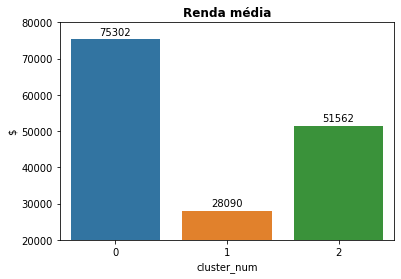

In [24]:
ax = sns.barplot(x='cluster_num', y='Income', data=df_mean)
ax.set_title('Renda média', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
ax.set_ylabel('$')
plt.ylim(20000, 80000)
plt.show();

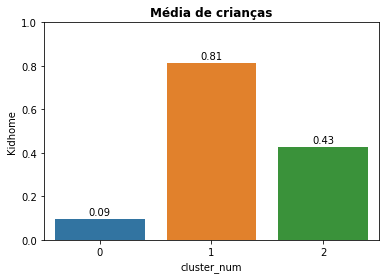

In [25]:
ax = sns.barplot(x='cluster_num', y='Kidhome', data=df_mean)
ax.set_title('Média de crianças', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 1)
plt.show();

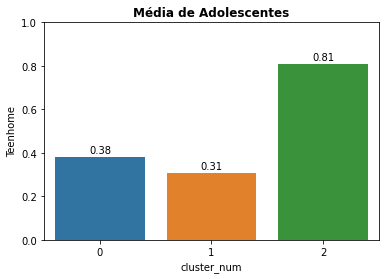

In [26]:
ax = sns.barplot(x='cluster_num', y='Teenhome', data=df_mean)
ax.set_title('Média de Adolescentes', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 1)
plt.show();

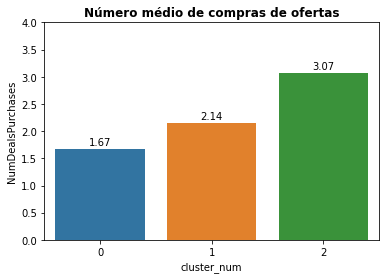

In [27]:
ax = sns.barplot(x='cluster_num', y='NumDealsPurchases', data=df_mean)
ax.set_title('Número médio de compras de ofertas', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 4)
plt.show();

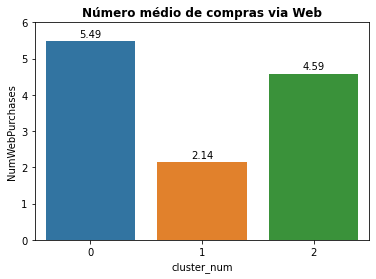

In [28]:
ax = sns.barplot(x='cluster_num', y='NumWebPurchases', data=df_mean)
ax.set_title('Número médio de compras via Web', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 6)
plt.show();

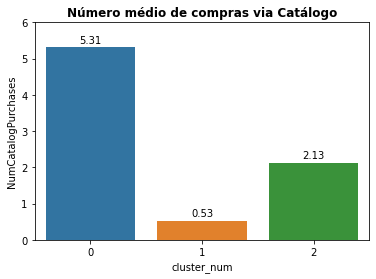

In [29]:
ax = sns.barplot(x='cluster_num', y='NumCatalogPurchases', data=df_mean)
ax.set_title('Número médio de compras via Catálogo', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 6)
plt.show();

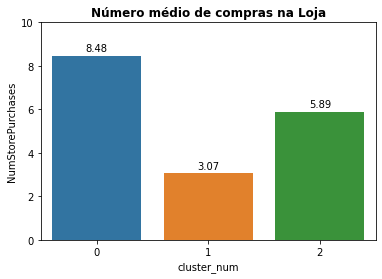

In [30]:
ax = sns.barplot(x='cluster_num', y='NumStorePurchases', data=df_mean)
ax.set_title('Número médio de compras na Loja', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 10)
plt.show();

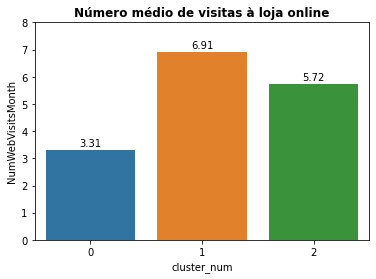

In [31]:
ax = sns.barplot(x='cluster_num', y='NumWebVisitsMonth', data=df_mean)
ax.set_title('Número médio de visitas à loja online', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 8)
plt.show();

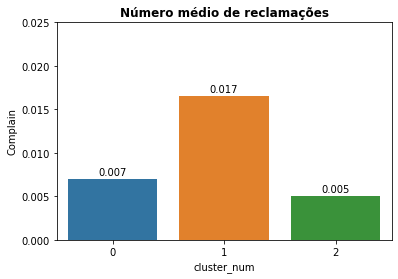

In [32]:
ax = sns.barplot(x='cluster_num', y='Complain', data=df_mean)
ax.set_title('Número médio de reclamações', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 0.025)
plt.show();

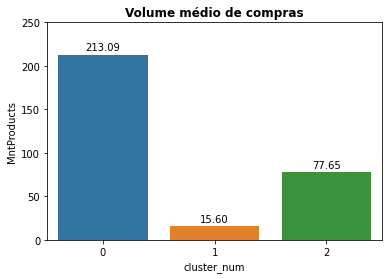

In [33]:
ax = sns.barplot(x='cluster_num', y='MntProducts', data=df_mean)
ax.set_title('Volume médio de compras', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 250)
plt.show();

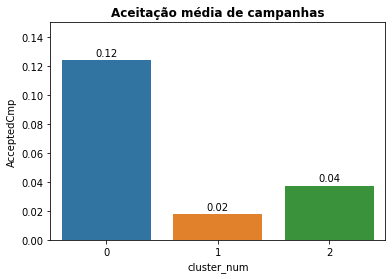

In [34]:
ax = sns.barplot(x='cluster_num', y='AcceptedCmp', data=df_mean)
ax.set_title('Aceitação média de campanhas', fontsize=12, fontweight='bold')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points')
plt.ylim(0, 0.15)
plt.show();